In [1]:
# Load python modules
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sns
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
class_names_label

{'Glass': 0, 'Metal': 1, 'Paper': 2, 'Textile': 3}

In [5]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [6]:
# Path to Dataset1e

# Dataset with 4 classes - 270 images for training and 50 images for testing per class
train_ds_1 = 'C:/Mani/Dataset/dataset1/train_ds'
test_ds_1 = 'C:/Mani/Dataset/dataset1/test_ds'

# Dataset with 4 classes - 450 images for training with data augmentation images and 50 images for testing
train_ds_2 = 'C:/Mani/Dataset/dataset2/train_ds'
test_ds_2 = 'C:/Mani/Dataset/dataset2/test_ds'

# Dataset with 6 classes - 450 images for training with data augmentation images and 50 images for testing
train_ds_3 = 'C:/Mani/Dataset/dataset3/train_ds'
test_ds_3 = 'C:/Mani/Dataset/dataset3/test_ds'



In [7]:
def load_data(train_path, test_path):
    """
        Load the data from local folder
        
    """
    datasets = [train_path, test_path]  
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        #Empty Image and Labels list
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [8]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data(train_ds_2, test_ds_2)

Loading C:/Mani/Dataset/dataset2/train_ds


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:12<00:00, 37.47it/s]


Loading C:/Mani/Dataset/dataset2/test_ds


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.61it/s]


In [9]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1800, 64, 64, 3), (200, 64, 64, 3))

In [10]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

In [11]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1800


In [12]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

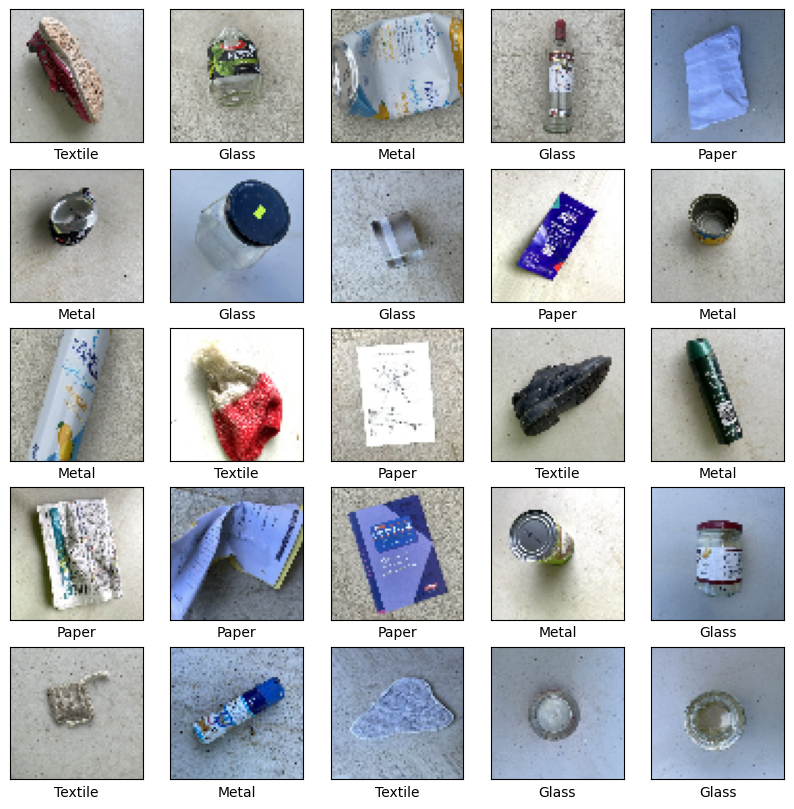

In [13]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [14]:
#Sequential Model 1
# Experience 3 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    # Block 1
    tf.keras.layers.Conv2D(32, (5,5), padding='valid', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.1),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='valid', kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.02), activation = 'relu'),   
    #tf.keras.layers.Dense(64, activation = 'hard_swish'),
    #tf.keras.layers.Dense(32, activation = 'relu6'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 316,484 (1.21 MB)

 Trainable params: 316,484 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    #Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='valid', kernel_regularizer=regularizers.l2(0.03), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block2
    tf.keras.layers.Conv2D(64, (3,3), padding='valid', kernel_regularizer=regularizers.l2(0.03), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.03), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.03), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.3),
       
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.005), activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu6'),
    #tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,484 (798.77 KB)

 Trainable params: 204,356 (798.27 KB)

 Non-trainable params: 128 (512.00 B)

In [16]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding= 'valid', kernel_regularizer=regularizers.l2(0.03), activation ='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding= 'valid', kernel_regularizer=regularizers.l2(0.04), activation ='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding= 'same', kernel_regularizer=regularizers.l2(0.04), activation ='relu'),
    #tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.04), activation ='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 5
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.04), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.04), activation ='relu'),
    #tf.keras.layers.Dense(16, activation = 'relu6'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 3, 3, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 3, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,820 (729.77 KB)

 Trainable params: 186,756 (729.52 KB)

 Non-trainable params: 64 (256.00 B)

In [17]:
# Add callbacks to save the model weight with best accuracy during training

#import ModelCheckpoint package
#from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [18]:
#Learning rate scheduler for Model 1 and 2

def scheduler1(epoch, lr):
    if epoch <= 100:
        return lr
    else:
        return lr * 0.98
        
    
lr_callback1 = LearningRateScheduler(scheduler1, verbose=1)

In [19]:
#Learning rate scheduler for Model 3

def scheduler2(epoch, lr):
    if epoch <= 150:
        return lr
    else:
        return lr * 0.98
        
    
lr_callback2 = LearningRateScheduler(scheduler2, verbose=1)

In [20]:
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * np.exp(-0.01)

lr_callback3 = LearningRateScheduler(scheduler)

In [21]:
model_1.compile(optimizer = tf.keras.optimizers.SGD(0.02),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.SGD(0.012),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.SGD(0.012),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [22]:
# Set number of epochs
epochs = 400
batch_size = 128

In [23]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.1, verbose=1,
                      callbacks=[lr_callback3, model_checkpoint_callback1])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)


Time model start: 2024-12-09 13:40:41.077509
Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2537 - loss: 6.6945
Epoch 1: val_accuracy improved from -inf to 0.26111, saving model to C:/Mani/ModelCheckpoint/model1.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.2541 - loss: 6.6927 - val_accuracy: 0.2611 - val_loss: 6.6052 - learning_rate: 0.0200
Epoch 2/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2856 - loss: 6.5828
Epoch 2: val_accuracy improved from 0.26111 to 0.40556, saving model to C:/Mani/ModelCheckpoint/model1.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.2875 - loss: 6.5789 - val_accuracy: 0.4056 - val_loss: 6.4964 - learning_rate: 0.0200
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3171 - loss: 6.4746
Epoch 3: val_accuracy did not improve from 0.40556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.3181 - loss: 6.4729 - val_accuracy: 0.2944 - val_loss: 6.3931 - learning_rate: 0.0200
Epoch 4/40

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4938 - loss: 4.6653
Epoch 23: val_accuracy did not improve from 0.55000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.4928 - loss: 4.6649 - val_accuracy: 0.5167 - val_loss: 4.6360 - learning_rate: 0.0200
Epoch 24/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4685 - loss: 4.5991
Epoch 24: val_accuracy did not improve from 0.55000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4688 - loss: 4.5980 - val_accuracy: 0.5500 - val_loss: 4.4841 - learning_rate: 0.0200
Epoch 25/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4755 - loss: 4.5374
Epoch 25: val_accuracy did not improve from 0.55000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4761 - loss: 4.5366 - val_accuracy: 0.5444 - val_loss: 4.4200 - learning_rate: 0.0200
Epoch 26/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4955 - loss: 4.4463
Epoch 26: val_accuracy did not improve from 0.55000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/st

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5273 - loss: 3.3523
Epoch 46: val_accuracy did not improve from 0.60556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5284 - loss: 3.3497 - val_accuracy: 0.6000 - val_loss: 3.1953 - learning_rate: 0.0200
Epoch 47/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5161 - loss: 3.2949
Epoch 47: val_accuracy did not improve from 0.60556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5174 - loss: 3.2924 - val_accuracy: 0.5833 - val_loss: 3.1859 - learning_rate: 0.0200
Epoch 48/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5274 - loss: 3.2302
Epoch 48: val_accuracy did not improve from 0.60556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5273 - loss: 3.2331 - val_accuracy: 0.5556 - val_loss: 3.1863 - learning_rate: 0.0200
Epoch 49/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5292 - loss: 3.1837
Epoch 49: val_accuracy did not improve from 0.60556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/st

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5973 - loss: 2.4722
Epoch 69: val_accuracy did not improve from 0.65556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5971 - loss: 2.4727 - val_accuracy: 0.6000 - val_loss: 2.4787 - learning_rate: 0.0165
Epoch 70/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6406 - loss: 2.4347
Epoch 70: val_accuracy did not improve from 0.65556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6389 - loss: 2.4355 - val_accuracy: 0.5556 - val_loss: 2.5209 - learning_rate: 0.0164
Epoch 71/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6094 - loss: 2.4312
Epoch 71: val_accuracy did not improve from 0.65556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6088 - loss: 2.4312 - val_accuracy: 0.5611 - val_loss: 2.4616 - learning_rate: 0.0162
Epoch 72/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6022 - loss: 2.4339
Epoch 72: val_accuracy did not improve from 0.65556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/st

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6581 - loss: 2.0158 - val_accuracy: 0.6444 - val_loss: 2.0221 - learning_rate: 0.0131
Epoch 93/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6492 - loss: 2.0094
Epoch 93: val_accuracy did not improve from 0.66667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6493 - loss: 2.0066 - val_accuracy: 0.6556 - val_loss: 1.9916 - learning_rate: 0.0130
Epoch 94/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6291 - loss: 1.9891
Epoch 94: val_accuracy did not improve from 0.66667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6296 - loss: 1.9895 - val_accuracy: 0.6222 - val_loss: 2.0295 - learning_rate: 0.0129
Epoch 95/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6467 - loss: 1.9789
Epoch 95: val_accuracy did not improve from 0.66667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6464 - loss: 1.9784 - val_accuracy: 0.6222 - val_loss: 1.9952 - learning_rate: 0.0128
Epoch 96/400
13/13 ━━━━

Epoch 116/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6640 - loss: 1.7273
Epoch 116: val_accuracy improved from 0.70000 to 0.70556, saving model to C:/Mani/ModelCheckpoint/model1.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6651 - loss: 1.7269 - val_accuracy: 0.7056 - val_loss: 1.7498 - learning_rate: 0.0103
Epoch 117/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6903 - loss: 1.7264
Epoch 117: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6895 - loss: 1.7240 - val_accuracy: 0.6833 - val_loss: 1.7702 - learning_rate: 0.0102
Epoch 118/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6739 - loss: 1.7151
Epoch 118: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6746 - loss: 1.7135 - val_accuracy: 0.6500 - val_loss: 1.7543 - learning_rate: 0.0101
Epoch 119/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7044 - loss: 1.6687
Epoch 119: 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6997 - loss: 1.5468
Epoch 139: val_accuracy improved from 0.71667 to 0.72222, saving model to C:/Mani/ModelCheckpoint/model1.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7001 - loss: 1.5468 - val_accuracy: 0.7222 - val_loss: 1.5846 - learning_rate: 0.0082
Epoch 140/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7035 - loss: 1.5122
Epoch 140: val_accuracy did not improve from 0.72222
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.7032 - loss: 1.5133 - val_accuracy: 0.6889 - val_loss: 1.5854 - learning_rate: 0.0081
Epoch 141/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7089 - loss: 1.5351
Epoch 141: val_accuracy did not improve from 0.72222
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7086 - loss: 1.5347 - val_accuracy: 0.6556 - val_loss: 1.5984 - learning_rate: 0.0081
Epoch 142/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6941 - loss: 1.5044
Epoch 142: val_accuracy 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7345 - loss: 1.3912
Epoch 162: val_accuracy did not improve from 0.73333
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7334 - loss: 1.3931 - val_accuracy: 0.7278 - val_loss: 1.4831 - learning_rate: 0.0065
Epoch 163/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7221 - loss: 1.4155
Epoch 163: val_accuracy did not improve from 0.73333
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.7225 - loss: 1.4151 - val_accuracy: 0.7333 - val_loss: 1.4890 - learning_rate: 0.0065
Epoch 164/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7104 - loss: 1.4207
Epoch 164: val_accuracy did not improve from 0.73333
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7108 - loss: 1.4196 - val_accuracy: 0.6944 - val_loss: 1.4865 - learning_rate: 0.0064
Epoch 165/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7247 - loss: 1.3988
Epoch 165: val_accuracy did not improve from 0.73333
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7242 - loss: 1.3338
Epoch 185: val_accuracy did not improve from 0.73889
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7247 - loss: 1.3338 - val_accuracy: 0.7278 - val_loss: 1.4028 - learning_rate: 0.0052
Epoch 186/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7227 - loss: 1.3553
Epoch 186: val_accuracy did not improve from 0.73889
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7239 - loss: 1.3532 - val_accuracy: 0.7167 - val_loss: 1.4026 - learning_rate: 0.0051
Epoch 187/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7301 - loss: 1.3295
Epoch 187: val_accuracy did not improve from 0.73889
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7302 - loss: 1.3295 - val_accuracy: 0.7056 - val_loss: 1.4206 - learning_rate: 0.0051
Epoch 188/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7317 - loss: 1.3260
Epoch 188: val_accuracy did not improve from 0.73889
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 209/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7303 - loss: 1.2716
Epoch 209: val_accuracy did not improve from 0.73889
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7312 - loss: 1.2713 - val_accuracy: 0.7333 - val_loss: 1.3539 - learning_rate: 0.0041
Epoch 210/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7291 - loss: 1.2794
Epoch 210: val_accuracy did not improve from 0.73889
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.7301 - loss: 1.2785 - val_accuracy: 0.6889 - val_loss: 1.3901 - learning_rate: 0.0040
Epoch 211/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7304 - loss: 1.2814
Epoch 211: val_accuracy did not improve from 0.73889
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7311 - loss: 1.2807 - val_accuracy: 0.7222 - val_loss: 1.3558 - learning_rate: 0.0040
Epoch 212/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7524 - loss: 1.2472
Epoch 212: val_accuracy did not improve from 0.73889
13/13 ━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7221 - loss: 1.2493
Epoch 232: val_accuracy did not improve from 0.74444
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7233 - loss: 1.2479 - val_accuracy: 0.7222 - val_loss: 1.3244 - learning_rate: 0.0032
Epoch 233/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7532 - loss: 1.2115
Epoch 233: val_accuracy did not improve from 0.74444
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7529 - loss: 1.2127 - val_accuracy: 0.7278 - val_loss: 1.3221 - learning_rate: 0.0032
Epoch 234/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7385 - loss: 1.2307
Epoch 234: val_accuracy did not improve from 0.74444
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7391 - loss: 1.2299 - val_accuracy: 0.7389 - val_loss: 1.3164 - learning_rate: 0.0032
Epoch 235/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7433 - loss: 1.2294
Epoch 235: val_accuracy did not improve from 0.74444
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7690 - loss: 1.1824
Epoch 255: val_accuracy did not improve from 0.75000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7683 - loss: 1.1834 - val_accuracy: 0.7500 - val_loss: 1.2922 - learning_rate: 0.0026
Epoch 256/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7575 - loss: 1.1898
Epoch 256: val_accuracy did not improve from 0.75000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7575 - loss: 1.1900 - val_accuracy: 0.7500 - val_loss: 1.2930 - learning_rate: 0.0025
Epoch 257/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7625 - loss: 1.1980
Epoch 257: val_accuracy did not improve from 0.75000
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7627 - loss: 1.1957 - val_accuracy: 0.7389 - val_loss: 1.2908 - learning_rate: 0.0025
Epoch 258/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7546 - loss: 1.1985
Epoch 258: val_accuracy did not improve from 0.75000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 279/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7514 - loss: 1.1772
Epoch 279: val_accuracy did not improve from 0.75000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7515 - loss: 1.1764 - val_accuracy: 0.7444 - val_loss: 1.2681 - learning_rate: 0.0020
Epoch 280/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7449 - loss: 1.1563
Epoch 280: val_accuracy did not improve from 0.75000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7452 - loss: 1.1571 - val_accuracy: 0.7389 - val_loss: 1.2699 - learning_rate: 0.0020
Epoch 281/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7505 - loss: 1.1642
Epoch 281: val_accuracy did not improve from 0.75000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7509 - loss: 1.1640 - val_accuracy: 0.7444 - val_loss: 1.2684 - learning_rate: 0.0020
Epoch 282/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7830 - loss: 1.1445
Epoch 282: val_accuracy improved from 0.75000 to 0.75556, saving mode

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7598 - loss: 1.1382
Epoch 302: val_accuracy did not improve from 0.75556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7599 - loss: 1.1387 - val_accuracy: 0.7500 - val_loss: 1.2529 - learning_rate: 0.0016
Epoch 303/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7711 - loss: 1.1186
Epoch 303: val_accuracy did not improve from 0.75556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7704 - loss: 1.1201 - val_accuracy: 0.7556 - val_loss: 1.2542 - learning_rate: 0.0016
Epoch 304/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7549 - loss: 1.1628
Epoch 304: val_accuracy did not improve from 0.75556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7553 - loss: 1.1621 - val_accuracy: 0.7444 - val_loss: 1.2579 - learning_rate: 0.0016
Epoch 305/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7637 - loss: 1.1380
Epoch 305: val_accuracy did not improve from 0.75556
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7480 - loss: 1.1548
Epoch 325: val_accuracy did not improve from 0.76111
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.7492 - loss: 1.1529 - val_accuracy: 0.7556 - val_loss: 1.2425 - learning_rate: 0.0013
Epoch 326/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7665 - loss: 1.1290
Epoch 326: val_accuracy did not improve from 0.76111
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7663 - loss: 1.1289 - val_accuracy: 0.7500 - val_loss: 1.2417 - learning_rate: 0.0013
Epoch 327/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7719 - loss: 1.1365
Epoch 327: val_accuracy did not improve from 0.76111
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7720 - loss: 1.1358 - val_accuracy: 0.7444 - val_loss: 1.2413 - learning_rate: 0.0013
Epoch 328/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7648 - loss: 1.1347
Epoch 328: val_accuracy did not improve from 0.76111
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7707 - loss: 1.1113
Epoch 348: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7703 - loss: 1.1127 - val_accuracy: 0.7556 - val_loss: 1.2326 - learning_rate: 0.0010
Epoch 349/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7524 - loss: 1.1376
Epoch 349: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7529 - loss: 1.1365 - val_accuracy: 0.7611 - val_loss: 1.2312 - learning_rate: 0.0010
Epoch 350/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7855 - loss: 1.0842
Epoch 350: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7846 - loss: 1.0859 - val_accuracy: 0.7556 - val_loss: 1.2296 - learning_rate: 9.9574e-04
Epoch 351/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7698 - loss: 1.1197
Epoch 351: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━━━━━━━━━

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7602 - loss: 1.1247
Epoch 371: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7615 - loss: 1.1219 - val_accuracy: 0.7611 - val_loss: 1.2272 - learning_rate: 8.0713e-04
Epoch 372/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7750 - loss: 1.1098
Epoch 372: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7744 - loss: 1.1098 - val_accuracy: 0.7500 - val_loss: 1.2248 - learning_rate: 7.9910e-04
Epoch 373/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7680 - loss: 1.0919
Epoch 373: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7684 - loss: 1.0923 - val_accuracy: 0.7389 - val_loss: 1.2260 - learning_rate: 7.9115e-04
Epoch 374/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7770 - loss: 1.1014
Epoch 374: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7507 - loss: 1.1297
Epoch 394: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7530 - loss: 1.1265 - val_accuracy: 0.7500 - val_loss: 1.2202 - learning_rate: 6.4129e-04
Epoch 395/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7585 - loss: 1.1189
Epoch 395: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7598 - loss: 1.1167 - val_accuracy: 0.7556 - val_loss: 1.2195 - learning_rate: 6.3491e-04
Epoch 396/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7597 - loss: 1.1191
Epoch 396: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7601 - loss: 1.1182 - val_accuracy: 0.7556 - val_loss: 1.2193 - learning_rate: 6.2860e-04
Epoch 397/400
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7800 - loss: 1.0900
Epoch 397: val_accuracy did not improve from 0.76667
13/13 ━━━━━━━━━━━━

In [24]:

# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.1, verbose=1,
                       callbacks=[lr_callback1, model_checkpoint_callback2])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time)


Time model start: 2024-12-09 13:48:35.325058

Epoch 1: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.2573 - loss: 8.6449
Epoch 1: val_accuracy improved from -inf to 0.26667, saving model to C:/Mani/ModelCheckpoint/model2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 595ms/step - accuracy: 0.2575 - loss: 8.6198 - val_accuracy: 0.2667 - val_loss: 7.8199 - learning_rate: 0.0120

Epoch 2: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2807 - loss: 7.9257
Epoch 2: val_accuracy did not improve from 0.26667
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.2811 - loss: 7.9221 - val_accuracy: 0.2333 - val_loss: 7.7017 - learning_rate: 0.0120

Epoch 3: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2963 - loss: 7.7436
Epoch 3: val_accu

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step - accuracy: 0.5567 - loss: 5.7177 - val_accuracy: 0.2778 - val_loss: 5.9450 - learning_rate: 0.0120

Epoch 20: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 20/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.5714 - loss: 5.5887
Epoch 20: val_accuracy did not improve from 0.43889
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.5712 - loss: 5.5875 - val_accuracy: 0.3167 - val_loss: 5.8331 - learning_rate: 0.0120

Epoch 21: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 21/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.5835 - loss: 5.5014
Epoch 21: val_accuracy did not improve from 0.43889
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.5833 - loss: 5.4993 - val_accuracy: 0.2889 - val_loss: 5.7667 - learning_rate: 0.0120

Epoch 22: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 22/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.6618 - loss: 4.1370
Epoch 38: val_accuracy did not improve from 0.59444
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step - accuracy: 0.6605 - loss: 4.1374 - val_accuracy: 0.5222 - val_loss: 4.3847 - learning_rate: 0.0120

Epoch 39: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 39/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6430 - loss: 4.1109
Epoch 39: val_accuracy did not improve from 0.59444
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - accuracy: 0.6417 - loss: 4.1114 - val_accuracy: 0.3944 - val_loss: 4.5507 - learning_rate: 0.0120

Epoch 40: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 40/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6596 - loss: 4.0195
Epoch 40: val_accuracy did not improve from 0.59444
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step - accuracy: 0.6596 - loss: 4.0190 - val_accuracy: 0.3889 - val_loss: 4.4770 - learning_rate: 0.0120

Epoch 41

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.6781 - loss: 3.1578
Epoch 57: val_accuracy improved from 0.59444 to 0.61667, saving model to C:/Mani/ModelCheckpoint/model2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 512ms/step - accuracy: 0.6775 - loss: 3.1567 - val_accuracy: 0.6167 - val_loss: 3.3073 - learning_rate: 0.0120

Epoch 58: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 58/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6834 - loss: 3.1271
Epoch 58: val_accuracy did not improve from 0.61667
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 466ms/step - accuracy: 0.6841 - loss: 3.1245 - val_accuracy: 0.5222 - val_loss: 3.3916 - learning_rate: 0.0120

Epoch 59: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 59/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7014 - loss: 3.0098
Epoch 59: val_accuracy did not improve from 0.61667
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - accuracy: 0.7007 - loss: 3.0112 - val_accuracy: 0


Epoch 76: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 76/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7147 - loss: 2.3868
Epoch 76: val_accuracy improved from 0.67222 to 0.71111, saving model to C:/Mani/ModelCheckpoint/model2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 436ms/step - accuracy: 0.7151 - loss: 2.3865 - val_accuracy: 0.7111 - val_loss: 2.4769 - learning_rate: 0.0120

Epoch 77: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 77/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7080 - loss: 2.3705
Epoch 77: val_accuracy did not improve from 0.71111
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.7079 - loss: 2.3705 - val_accuracy: 0.6056 - val_loss: 2.5622 - learning_rate: 0.0120

Epoch 78: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 78/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6900 - loss: 2.3648
Epoch 78: val_accuracy did not improve from 0.71111



Epoch 95: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 95/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7436 - loss: 1.8708
Epoch 95: val_accuracy did not improve from 0.71111
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step - accuracy: 0.7435 - loss: 1.8711 - val_accuracy: 0.6833 - val_loss: 1.9611 - learning_rate: 0.0120

Epoch 96: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 96/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7688 - loss: 1.8131
Epoch 96: val_accuracy did not improve from 0.71111
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step - accuracy: 0.7682 - loss: 1.8142 - val_accuracy: 0.6278 - val_loss: 2.0819 - learning_rate: 0.0120

Epoch 97: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 97/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.7355 - loss: 1.8450
Epoch 97: val_accuracy improved from 0.71111 to 0.72222, saving model to C:/Mani/ModelCheckpoint/model2.keras



Epoch 114: LearningRateScheduler setting learning rate to 0.009228269588202238.
Epoch 114/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.7694 - loss: 1.5076
Epoch 114: val_accuracy did not improve from 0.75000
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - accuracy: 0.7702 - loss: 1.5071 - val_accuracy: 0.6833 - val_loss: 1.6822 - learning_rate: 0.0092

Epoch 115: LearningRateScheduler setting learning rate to 0.00904370417818427.
Epoch 115/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.7749 - loss: 1.5182
Epoch 115: val_accuracy did not improve from 0.75000
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.7754 - loss: 1.5172 - val_accuracy: 0.7389 - val_loss: 1.5806 - learning_rate: 0.0090

Epoch 116: LearningRateScheduler setting learning rate to 0.008862829711288213.
Epoch 116/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7470 - loss: 1.5327
Epoch 116: val_accuracy did not improve from 0.75000
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accurac

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 415ms/step - accuracy: 0.8035 - loss: 1.3025 - val_accuracy: 0.6778 - val_loss: 1.6460 - learning_rate: 0.0064

Epoch 133: LearningRateScheduler setting learning rate to 0.006286597959697247.
Epoch 133/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8095 - loss: 1.3000
Epoch 133: val_accuracy did not improve from 0.78889
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.8091 - loss: 1.2997 - val_accuracy: 0.7278 - val_loss: 1.5321 - learning_rate: 0.0063

Epoch 134: LearningRateScheduler setting learning rate to 0.006160865854471922.
Epoch 134/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7980 - loss: 1.3232
Epoch 134: val_accuracy did not improve from 0.78889
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 387ms/step - accuracy: 0.7982 - loss: 1.3213 - val_accuracy: 0.7611 - val_loss: 1.3849 - learning_rate: 0.0062

Epoch 135: LearningRateScheduler setting learning rate to 0.006037648683413863.
Epoch 135/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 420ms/step - accuracy: 0.8143 - loss: 1.1755 - val_accuracy: 0.7056 - val_loss: 1.4431 - learning_rate: 0.0044

Epoch 152: LearningRateScheduler setting learning rate to 0.004282635804265737.
Epoch 152/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8193 - loss: 1.1758
Epoch 152: val_accuracy did not improve from 0.78889
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 401ms/step - accuracy: 0.8190 - loss: 1.1764 - val_accuracy: 0.7333 - val_loss: 1.3513 - learning_rate: 0.0043

Epoch 153: LearningRateScheduler setting learning rate to 0.00419698292389512.
Epoch 153/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8307 - loss: 1.1791
Epoch 153: val_accuracy did not improve from 0.78889
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step - accuracy: 0.8305 - loss: 1.1784 - val_accuracy: 0.7389 - val_loss: 1.3539 - learning_rate: 0.0042

Epoch 154: LearningRateScheduler setting learning rate to 0.0041130431741476054.
Epoch 154/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8387 - loss: 1.0892
Epoch 170: val_accuracy did not improve from 0.80556
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step - accuracy: 0.8387 - loss: 1.0898 - val_accuracy: 0.8000 - val_loss: 1.1987 - learning_rate: 0.0030

Epoch 171: LearningRateScheduler setting learning rate to 0.002917471034452319.
Epoch 171/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8240 - loss: 1.1007
Epoch 171: val_accuracy did not improve from 0.80556
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 421ms/step - accuracy: 0.8245 - loss: 1.1000 - val_accuracy: 0.7944 - val_loss: 1.2406 - learning_rate: 0.0029

Epoch 172: LearningRateScheduler setting learning rate to 0.0028591216867789628.
Epoch 172/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8542 - loss: 1.0591
Epoch 172: val_accuracy did not improve from 0.80556
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - accuracy: 0.8532 - loss: 1.0606 - val_accuracy: 0.7889 - val_loss: 1.2304 - learning_rate: 0.0029



Epoch 189/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8398 - loss: 1.0476
Epoch 189: val_accuracy improved from 0.81111 to 0.81667, saving model to C:/Mani/ModelCheckpoint/model2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.8397 - loss: 1.0478 - val_accuracy: 0.8167 - val_loss: 1.1678 - learning_rate: 0.0020

Epoch 190: LearningRateScheduler setting learning rate to 0.001987476125359535.
Epoch 190/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8312 - loss: 1.0467
Epoch 190: val_accuracy did not improve from 0.81667
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 434ms/step - accuracy: 0.8312 - loss: 1.0469 - val_accuracy: 0.7833 - val_loss: 1.1930 - learning_rate: 0.0020

Epoch 191: LearningRateScheduler setting learning rate to 0.0019477266119793057.
Epoch 191/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8556 - loss: 1.0242
Epoch 191: val_accuracy did not improve from 0.81667
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.8548 - loss: 1.0


Epoch 208: LearningRateScheduler setting learning rate to 0.0013815648923628033.
Epoch 208/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8450 - loss: 1.0223
Epoch 208: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step - accuracy: 0.8451 - loss: 1.0214 - val_accuracy: 0.7889 - val_loss: 1.1732 - learning_rate: 0.0014

Epoch 209: LearningRateScheduler setting learning rate to 0.0013539335876703261.
Epoch 209/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8258 - loss: 1.0341
Epoch 209: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step - accuracy: 0.8266 - loss: 1.0335 - val_accuracy: 0.8222 - val_loss: 1.1546 - learning_rate: 0.0014

Epoch 210: LearningRateScheduler setting learning rate to 0.0013268549204804004.
Epoch 210/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8559 - loss: 0.9950
Epoch 210: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step - acc


Epoch 227: LearningRateScheduler setting learning rate to 0.0009411671652924269.
Epoch 227/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.8464 - loss: 0.9935
Epoch 227: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 523ms/step - accuracy: 0.8465 - loss: 0.9939 - val_accuracy: 0.8056 - val_loss: 1.1178 - learning_rate: 9.4117e-04

Epoch 228: LearningRateScheduler setting learning rate to 0.0009223438345361501.
Epoch 228/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8507 - loss: 0.9861
Epoch 228: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 439ms/step - accuracy: 0.8506 - loss: 0.9867 - val_accuracy: 0.8056 - val_loss: 1.1145 - learning_rate: 9.2234e-04

Epoch 229: LearningRateScheduler setting learning rate to 0.0009038969338871539.
Epoch 229/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8595 - loss: 0.9995
Epoch 229: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/s


Epoch 246: LearningRateScheduler setting learning rate to 0.0006411537388339638.
Epoch 246/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8443 - loss: 0.9890
Epoch 246: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.8449 - loss: 0.9885 - val_accuracy: 0.8111 - val_loss: 1.1187 - learning_rate: 6.4115e-04

Epoch 247: LearningRateScheduler setting learning rate to 0.0006283306435216218.
Epoch 247/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8613 - loss: 0.9716
Epoch 247: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 446ms/step - accuracy: 0.8609 - loss: 0.9722 - val_accuracy: 0.8167 - val_loss: 1.1099 - learning_rate: 6.2833e-04

Epoch 248: LearningRateScheduler setting learning rate to 0.0006157640158198774.
Epoch 248/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8648 - loss: 0.9892
Epoch 248: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 426ms/st


Epoch 265: LearningRateScheduler setting learning rate to 0.00043677477980963886.
Epoch 265/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8392 - loss: 0.9824
Epoch 265: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step - accuracy: 0.8399 - loss: 0.9816 - val_accuracy: 0.8056 - val_loss: 1.1079 - learning_rate: 4.3677e-04

Epoch 266: LearningRateScheduler setting learning rate to 0.00042803927964996547.
Epoch 266/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8538 - loss: 0.9609
Epoch 266: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step - accuracy: 0.8536 - loss: 0.9617 - val_accuracy: 0.7944 - val_loss: 1.1248 - learning_rate: 4.2804e-04

Epoch 267: LearningRateScheduler setting learning rate to 0.0004194785037543625.
Epoch 267/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8556 - loss: 0.9662
Epoch 267: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms


Epoch 284: LearningRateScheduler setting learning rate to 0.00029754526796750726.
Epoch 284/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8460 - loss: 0.9605
Epoch 284: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 529ms/step - accuracy: 0.8467 - loss: 0.9601 - val_accuracy: 0.8167 - val_loss: 1.0933 - learning_rate: 2.9755e-04

Epoch 285: LearningRateScheduler setting learning rate to 0.0002915943751577288.
Epoch 285/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8471 - loss: 0.9659
Epoch 285: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 524ms/step - accuracy: 0.8479 - loss: 0.9654 - val_accuracy: 0.8167 - val_loss: 1.0893 - learning_rate: 2.9159e-04

Epoch 286: LearningRateScheduler setting learning rate to 0.0002857624751050025.
Epoch 286/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8510 - loss: 0.9705
Epoch 286: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/


Epoch 303: LearningRateScheduler setting learning rate to 0.00020269754459150134.
Epoch 303/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8374 - loss: 0.9845
Epoch 303: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 477ms/step - accuracy: 0.8377 - loss: 0.9841 - val_accuracy: 0.8167 - val_loss: 1.0942 - learning_rate: 2.0270e-04

Epoch 304: LearningRateScheduler setting learning rate to 0.00019864359084749593.
Epoch 304/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8645 - loss: 0.9536
Epoch 304: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 415ms/step - accuracy: 0.8644 - loss: 0.9533 - val_accuracy: 0.8111 - val_loss: 1.0908 - learning_rate: 1.9864e-04

Epoch 305: LearningRateScheduler setting learning rate to 0.00019467072444967926.
Epoch 305/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8511 - loss: 0.9507
Epoch 305: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 427ms


Epoch 322: LearningRateScheduler setting learning rate to 0.0001380841780337505.
Epoch 322/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8590 - loss: 0.9554
Epoch 322: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 452ms/step - accuracy: 0.8586 - loss: 0.9557 - val_accuracy: 0.8111 - val_loss: 1.0949 - learning_rate: 1.3808e-04

Epoch 323: LearningRateScheduler setting learning rate to 0.00013532248791307212.
Epoch 323/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8530 - loss: 0.9613
Epoch 323: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 470ms/step - accuracy: 0.8530 - loss: 0.9614 - val_accuracy: 0.8111 - val_loss: 1.0934 - learning_rate: 1.3532e-04

Epoch 324: LearningRateScheduler setting learning rate to 0.0001326160444295965.
Epoch 324/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8573 - loss: 0.9527
Epoch 324: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 439ms/s


Epoch 341: LearningRateScheduler setting learning rate to 9.406745375599712e-05.
Epoch 341/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8566 - loss: 0.9464
Epoch 341: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.8564 - loss: 0.9467 - val_accuracy: 0.8111 - val_loss: 1.0887 - learning_rate: 9.4067e-05

Epoch 342: LearningRateScheduler setting learning rate to 9.218610182870179e-05.
Epoch 342/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8620 - loss: 0.9315
Epoch 342: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.8615 - loss: 0.9322 - val_accuracy: 0.8111 - val_loss: 1.0899 - learning_rate: 9.2186e-05

Epoch 343: LearningRateScheduler setting learning rate to 9.034237722516991e-05.
Epoch 343/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8526 - loss: 0.9663
Epoch 343: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 402ms/st


Epoch 360: LearningRateScheduler setting learning rate to 6.408180663129314e-05.
Epoch 360/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8696 - loss: 0.9182
Epoch 360: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.8686 - loss: 0.9194 - val_accuracy: 0.8167 - val_loss: 1.0905 - learning_rate: 6.4082e-05

Epoch 361: LearningRateScheduler setting learning rate to 6.280016736127436e-05.
Epoch 361/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8375 - loss: 0.9784
Epoch 361: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.8385 - loss: 0.9761 - val_accuracy: 0.8111 - val_loss: 1.0888 - learning_rate: 6.2800e-05

Epoch 362: LearningRateScheduler setting learning rate to 6.154416201752611e-05.
Epoch 362/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8482 - loss: 0.9503
Epoch 362: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/st


Epoch 379: LearningRateScheduler setting learning rate to 4.365461565612349e-05.
Epoch 379/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8709 - loss: 0.9236
Epoch 379: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.8710 - loss: 0.9241 - val_accuracy: 0.8111 - val_loss: 1.0882 - learning_rate: 4.3655e-05

Epoch 380: LearningRateScheduler setting learning rate to 4.278152198821772e-05.
Epoch 380/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8501 - loss: 0.9502
Epoch 380: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.8504 - loss: 0.9499 - val_accuracy: 0.8111 - val_loss: 1.0887 - learning_rate: 4.2782e-05

Epoch 381: LearningRateScheduler setting learning rate to 4.192589076410513e-05.
Epoch 381/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8535 - loss: 0.9404
Epoch 381: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/st


Epoch 398: LearningRateScheduler setting learning rate to 2.9738944649579933e-05.
Epoch 398/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8697 - loss: 0.9333
Epoch 398: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.8692 - loss: 0.9338 - val_accuracy: 0.8167 - val_loss: 1.0870 - learning_rate: 2.9739e-05

Epoch 399: LearningRateScheduler setting learning rate to 2.9144166255719028e-05.
Epoch 399/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8717 - loss: 0.9272
Epoch 399: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.8713 - loss: 0.9279 - val_accuracy: 0.8167 - val_loss: 1.0874 - learning_rate: 2.9144e-05

Epoch 400: LearningRateScheduler setting learning rate to 2.8561283215822186e-05.
Epoch 400/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8412 - loss: 0.9519
Epoch 400: val_accuracy did not improve from 0.82222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms

In [25]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.1, verbose=1,
                       callbacks=[lr_callback1, model_checkpoint_callback3])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-12-09 14:25:13.442238

Epoch 1: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.2639 - loss: 13.2555
Epoch 1: val_accuracy improved from -inf to 0.27222, saving model to C:/Mani/ModelCheckpoint/model3.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.2638 - loss: 13.2452 - val_accuracy: 0.2722 - val_loss: 12.7206 - learning_rate: 0.0120

Epoch 2: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.2819 - loss: 12.6901
Epoch 2: val_accuracy did not improve from 0.27222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.2810 - loss: 12.6853 - val_accuracy: 0.2611 - val_loss: 12.4378 - learning_rate: 0.0120

Epoch 3: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.2775 - loss: 12.3768
Epoch 3: va

Epoch 19/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4559 - loss: 8.5927
Epoch 19: val_accuracy did not improve from 0.38889
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4557 - loss: 8.5905 - val_accuracy: 0.2889 - val_loss: 8.6264 - learning_rate: 0.0120

Epoch 20: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 20/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.4919 - loss: 8.3926
Epoch 20: val_accuracy did not improve from 0.38889
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4910 - loss: 8.3906 - val_accuracy: 0.3000 - val_loss: 8.4592 - learning_rate: 0.0120

Epoch 21: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 21/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.4945 - loss: 8.2227
Epoch 21: val_accuracy did not improve from 0.38889
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.4942 - loss: 8.2194 - val_accuracy: 0.3000 - val_loss: 8.2711 - learning_rate: 0.01


Epoch 38: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 38/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5537 - loss: 5.7125
Epoch 38: val_accuracy did not improve from 0.57222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.5537 - loss: 5.7119 - val_accuracy: 0.5333 - val_loss: 5.7773 - learning_rate: 0.0120

Epoch 39: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 39/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5784 - loss: 5.5689
Epoch 39: val_accuracy did not improve from 0.57222
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5780 - loss: 5.5679 - val_accuracy: 0.5278 - val_loss: 5.6478 - learning_rate: 0.0120

Epoch 40: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 40/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5984 - loss: 5.4684
Epoch 40: val_accuracy improved from 0.57222 to 0.59444, saving model to C:/Mani/ModelCheckpoint/model3.keras



Epoch 57: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 57/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6145 - loss: 3.9322
Epoch 57: val_accuracy did not improve from 0.59444
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.6145 - loss: 3.9316 - val_accuracy: 0.4667 - val_loss: 4.1770 - learning_rate: 0.0120

Epoch 58: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 58/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5881 - loss: 3.9020
Epoch 58: val_accuracy did not improve from 0.59444
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.5888 - loss: 3.9002 - val_accuracy: 0.4722 - val_loss: 4.0841 - learning_rate: 0.0120

Epoch 59: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 59/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6252 - loss: 3.7828
Epoch 59: val_accuracy did not improve from 0.59444
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.624


Epoch 76: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 76/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6291 - loss: 2.8489
Epoch 76: val_accuracy did not improve from 0.64444
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.6292 - loss: 2.8483 - val_accuracy: 0.6278 - val_loss: 2.8222 - learning_rate: 0.0120

Epoch 77: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 77/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6291 - loss: 2.7959
Epoch 77: val_accuracy did not improve from 0.64444
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.6293 - loss: 2.7974 - val_accuracy: 0.4722 - val_loss: 3.1941 - learning_rate: 0.0120

Epoch 78: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 78/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6202 - loss: 2.8041
Epoch 78: val_accuracy did not improve from 0.64444
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.621


Epoch 95: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 95/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6428 - loss: 2.1947
Epoch 95: val_accuracy did not improve from 0.67778
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.6424 - loss: 2.1942 - val_accuracy: 0.6056 - val_loss: 2.1898 - learning_rate: 0.0120

Epoch 96: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 96/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6635 - loss: 2.1335
Epoch 96: val_accuracy did not improve from 0.67778
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.6634 - loss: 2.1334 - val_accuracy: 0.4778 - val_loss: 2.4645 - learning_rate: 0.0120

Epoch 97: LearningRateScheduler setting learning rate to 0.012000000104308128.
Epoch 97/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6602 - loss: 2.1167
Epoch 97: val_accuracy did not improve from 0.67778
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.659


Epoch 114: LearningRateScheduler setting learning rate to 0.009228269588202238.
Epoch 114/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6704 - loss: 1.7284
Epoch 114: val_accuracy did not improve from 0.67778
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.6702 - loss: 1.7292 - val_accuracy: 0.6444 - val_loss: 1.7936 - learning_rate: 0.0092

Epoch 115: LearningRateScheduler setting learning rate to 0.00904370417818427.
Epoch 115/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6698 - loss: 1.7149
Epoch 115: val_accuracy did not improve from 0.67778
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.6684 - loss: 1.7170 - val_accuracy: 0.6556 - val_loss: 1.7414 - learning_rate: 0.0090

Epoch 116: LearningRateScheduler setting learning rate to 0.008862829711288213.
Epoch 116/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6558 - loss: 1.7436
Epoch 116: val_accuracy did not improve from 0.67778
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accurac


Epoch 133: LearningRateScheduler setting learning rate to 0.006286597959697247.
Epoch 133/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7128 - loss: 1.5223
Epoch 133: val_accuracy did not improve from 0.68889
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.7114 - loss: 1.5233 - val_accuracy: 0.5500 - val_loss: 1.8018 - learning_rate: 0.0063

Epoch 134: LearningRateScheduler setting learning rate to 0.006160865854471922.
Epoch 134/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.6755 - loss: 1.5636
Epoch 134: val_accuracy improved from 0.68889 to 0.69444, saving model to C:/Mani/ModelCheckpoint/model3.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.6757 - loss: 1.5622 - val_accuracy: 0.6944 - val_loss: 1.5304 - learning_rate: 0.0062

Epoch 135: LearningRateScheduler setting learning rate to 0.006037648683413863.
Epoch 135/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6919 - loss: 1.5196
Epoch 135: val_accuracy did not improve from


Epoch 152: LearningRateScheduler setting learning rate to 0.004282635804265737.
Epoch 152/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7034 - loss: 1.4323
Epoch 152: val_accuracy did not improve from 0.69444
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.7037 - loss: 1.4318 - val_accuracy: 0.6556 - val_loss: 1.4336 - learning_rate: 0.0043

Epoch 153: LearningRateScheduler setting learning rate to 0.00419698292389512.
Epoch 153/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6795 - loss: 1.4793
Epoch 153: val_accuracy improved from 0.69444 to 0.70000, saving model to C:/Mani/ModelCheckpoint/model3.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.6805 - loss: 1.4763 - val_accuracy: 0.7000 - val_loss: 1.4193 - learning_rate: 0.0042

Epoch 154: LearningRateScheduler setting learning rate to 0.0041130431741476054.
Epoch 154/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6984 - loss: 1.4175
Epoch 154: val_accuracy did not improve from


Epoch 171: LearningRateScheduler setting learning rate to 0.002917471034452319.
Epoch 171/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.6923 - loss: 1.3918
Epoch 171: val_accuracy did not improve from 0.70000
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.6928 - loss: 1.3906 - val_accuracy: 0.6667 - val_loss: 1.3804 - learning_rate: 0.0029

Epoch 172: LearningRateScheduler setting learning rate to 0.0028591216867789628.
Epoch 172/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6892 - loss: 1.3805
Epoch 172: val_accuracy did not improve from 0.70000
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.6906 - loss: 1.3784 - val_accuracy: 0.6722 - val_loss: 1.3799 - learning_rate: 0.0029

Epoch 173: LearningRateScheduler setting learning rate to 0.002801939221099019.
Epoch 173/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7009 - loss: 1.3425
Epoch 173: val_accuracy did not improve from 0.70000
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accur


Epoch 190: LearningRateScheduler setting learning rate to 0.001987476125359535.
Epoch 190/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6913 - loss: 1.3477
Epoch 190: val_accuracy did not improve from 0.70000
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.6918 - loss: 1.3471 - val_accuracy: 0.7000 - val_loss: 1.3346 - learning_rate: 0.0020

Epoch 191: LearningRateScheduler setting learning rate to 0.0019477266119793057.
Epoch 191/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7244 - loss: 1.3200
Epoch 191: val_accuracy improved from 0.70000 to 0.70556, saving model to C:/Mani/ModelCheckpoint/model3.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.7231 - loss: 1.3207 - val_accuracy: 0.7056 - val_loss: 1.3304 - learning_rate: 0.0019

Epoch 192: LearningRateScheduler setting learning rate to 0.0019087720569223165.
Epoch 192/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7183 - loss: 1.3117
Epoch 192: val_accuracy did not improve fr


Epoch 209: LearningRateScheduler setting learning rate to 0.0013539335876703261.
Epoch 209/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7092 - loss: 1.3192
Epoch 209: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.7093 - loss: 1.3186 - val_accuracy: 0.7000 - val_loss: 1.3128 - learning_rate: 0.0014

Epoch 210: LearningRateScheduler setting learning rate to 0.0013268549204804004.
Epoch 210/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6833 - loss: 1.3388
Epoch 210: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.6844 - loss: 1.3358 - val_accuracy: 0.6667 - val_loss: 1.3176 - learning_rate: 0.0013

Epoch 211: LearningRateScheduler setting learning rate to 0.0013003178243525327.
Epoch 211/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7103 - loss: 1.2911
Epoch 211: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - acc


Epoch 228: LearningRateScheduler setting learning rate to 0.0009223438345361501.
Epoch 228/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7133 - loss: 1.2911
Epoch 228: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.7131 - loss: 1.2902 - val_accuracy: 0.6667 - val_loss: 1.2964 - learning_rate: 9.2234e-04

Epoch 229: LearningRateScheduler setting learning rate to 0.0009038969338871539.
Epoch 229/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6904 - loss: 1.3083
Epoch 229: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.6913 - loss: 1.3057 - val_accuracy: 0.6778 - val_loss: 1.2937 - learning_rate: 9.0390e-04

Epoch 230: LearningRateScheduler setting learning rate to 0.0008858189906459301.
Epoch 230/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.7022 - loss: 1.2743
Epoch 230: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/st


Epoch 247: LearningRateScheduler setting learning rate to 0.0006283306435216218.
Epoch 247/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7176 - loss: 1.2767
Epoch 247: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.7174 - loss: 1.2764 - val_accuracy: 0.6778 - val_loss: 1.2860 - learning_rate: 6.2833e-04

Epoch 248: LearningRateScheduler setting learning rate to 0.0006157640158198774.
Epoch 248/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7045 - loss: 1.2706
Epoch 248: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.7046 - loss: 1.2707 - val_accuracy: 0.6722 - val_loss: 1.2854 - learning_rate: 6.1576e-04

Epoch 249: LearningRateScheduler setting learning rate to 0.000603448721813038.
Epoch 249/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7087 - loss: 1.2771
Epoch 249: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/ste


Epoch 266: LearningRateScheduler setting learning rate to 0.00042803927964996547.
Epoch 266/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7028 - loss: 1.2707
Epoch 266: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.7036 - loss: 1.2697 - val_accuracy: 0.6833 - val_loss: 1.2748 - learning_rate: 4.2804e-04

Epoch 267: LearningRateScheduler setting learning rate to 0.0004194785037543625.
Epoch 267/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7157 - loss: 1.2769
Epoch 267: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.7156 - loss: 1.2755 - val_accuracy: 0.6778 - val_loss: 1.2730 - learning_rate: 4.1948e-04

Epoch 268: LearningRateScheduler setting learning rate to 0.0004110889439471066.
Epoch 268/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7130 - loss: 1.2449
Epoch 268: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/s


Epoch 285: LearningRateScheduler setting learning rate to 0.0002915943751577288.
Epoch 285/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6921 - loss: 1.2818
Epoch 285: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.6936 - loss: 1.2806 - val_accuracy: 0.6889 - val_loss: 1.2726 - learning_rate: 2.9159e-04

Epoch 286: LearningRateScheduler setting learning rate to 0.0002857624751050025.
Epoch 286/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7123 - loss: 1.2308
Epoch 286: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.7121 - loss: 1.2322 - val_accuracy: 0.7056 - val_loss: 1.2672 - learning_rate: 2.8576e-04

Epoch 287: LearningRateScheduler setting learning rate to 0.0002800472290255129.
Epoch 287/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7146 - loss: 1.2483
Epoch 287: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/st


Epoch 304: LearningRateScheduler setting learning rate to 0.00019864359084749593.
Epoch 304/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7325 - loss: 1.2169
Epoch 304: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.7316 - loss: 1.2189 - val_accuracy: 0.6944 - val_loss: 1.2621 - learning_rate: 1.9864e-04

Epoch 305: LearningRateScheduler setting learning rate to 0.00019467072444967926.
Epoch 305/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7217 - loss: 1.2371
Epoch 305: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.7209 - loss: 1.2392 - val_accuracy: 0.6778 - val_loss: 1.2667 - learning_rate: 1.9467e-04

Epoch 306: LearningRateScheduler setting learning rate to 0.00019077730539720505.
Epoch 306/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7120 - loss: 1.2778
Epoch 306: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms


Epoch 323: LearningRateScheduler setting learning rate to 0.00013532248791307212.
Epoch 323/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7248 - loss: 1.2239
Epoch 323: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.7245 - loss: 1.2250 - val_accuracy: 0.6833 - val_loss: 1.2646 - learning_rate: 1.3532e-04

Epoch 324: LearningRateScheduler setting learning rate to 0.0001326160444295965.
Epoch 324/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7190 - loss: 1.2424
Epoch 324: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.7186 - loss: 1.2435 - val_accuracy: 0.6889 - val_loss: 1.2640 - learning_rate: 1.3262e-04

Epoch 325: LearningRateScheduler setting learning rate to 0.00012996372097404674.
Epoch 325/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.7054 - loss: 1.2741
Epoch 325: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/


Epoch 342: LearningRateScheduler setting learning rate to 9.218610182870179e-05.
Epoch 342/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.7336 - loss: 1.2326
Epoch 342: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.7335 - loss: 1.2327 - val_accuracy: 0.6889 - val_loss: 1.2631 - learning_rate: 9.2186e-05

Epoch 343: LearningRateScheduler setting learning rate to 9.034237722516991e-05.
Epoch 343/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.7185 - loss: 1.2528
Epoch 343: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.7184 - loss: 1.2527 - val_accuracy: 0.6889 - val_loss: 1.2640 - learning_rate: 9.0342e-05

Epoch 344: LearningRateScheduler setting learning rate to 8.853553124936297e-05.
Epoch 344/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7363 - loss: 1.2268
Epoch 344: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/st


Epoch 361: LearningRateScheduler setting learning rate to 6.280016736127436e-05.
Epoch 361/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7213 - loss: 1.2497
Epoch 361: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.7208 - loss: 1.2497 - val_accuracy: 0.6889 - val_loss: 1.2611 - learning_rate: 6.2800e-05

Epoch 362: LearningRateScheduler setting learning rate to 6.154416201752611e-05.
Epoch 362/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7163 - loss: 1.2388
Epoch 362: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.7155 - loss: 1.2398 - val_accuracy: 0.7000 - val_loss: 1.2605 - learning_rate: 6.1544e-05

Epoch 363: LearningRateScheduler setting learning rate to 6.031327720847912e-05.
Epoch 363/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7089 - loss: 1.2737
Epoch 363: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/st


Epoch 380: LearningRateScheduler setting learning rate to 4.278152198821772e-05.
Epoch 380/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.7330 - loss: 1.2357
Epoch 380: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.7325 - loss: 1.2361 - val_accuracy: 0.6889 - val_loss: 1.2616 - learning_rate: 4.2782e-05

Epoch 381: LearningRateScheduler setting learning rate to 4.192589076410513e-05.
Epoch 381/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7189 - loss: 1.2578
Epoch 381: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.7198 - loss: 1.2567 - val_accuracy: 0.6889 - val_loss: 1.2611 - learning_rate: 4.1926e-05

Epoch 382: LearningRateScheduler setting learning rate to 4.108737259230111e-05.
Epoch 382/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7077 - loss: 1.2486
Epoch 382: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/st


Epoch 399: LearningRateScheduler setting learning rate to 2.9144166255719028e-05.
Epoch 399/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6957 - loss: 1.2663
Epoch 399: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.6965 - loss: 1.2653 - val_accuracy: 0.6944 - val_loss: 1.2601 - learning_rate: 2.9144e-05

Epoch 400: LearningRateScheduler setting learning rate to 2.8561283215822186e-05.
Epoch 400/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7225 - loss: 1.2452
Epoch 400: val_accuracy did not improve from 0.70556
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.7220 - loss: 1.2458 - val_accuracy: 0.6944 - val_loss: 1.2601 - learning_rate: 2.8561e-05
Time model end: 2024-12-09 14:45:51.278341
Model_3_training_time 0:20:37.836103


Text(0.5, 1.0, 'Model 1 Accuracy (Exp:5.3)')

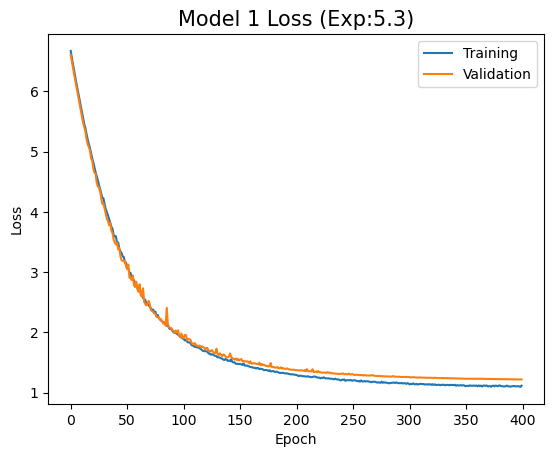

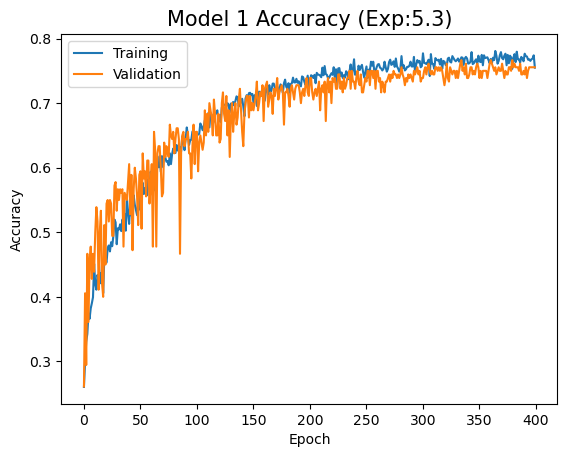

In [26]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:5.3)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:5.3)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp:5.3)')

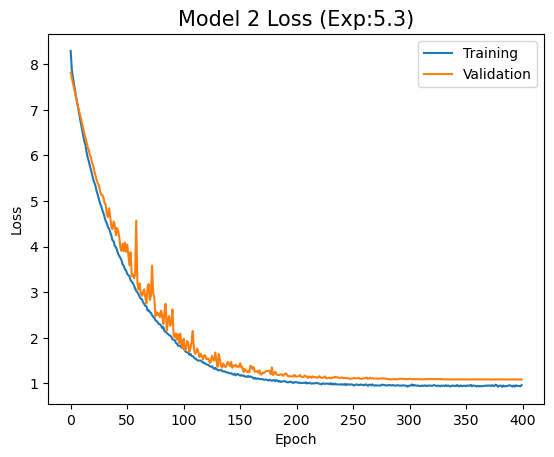

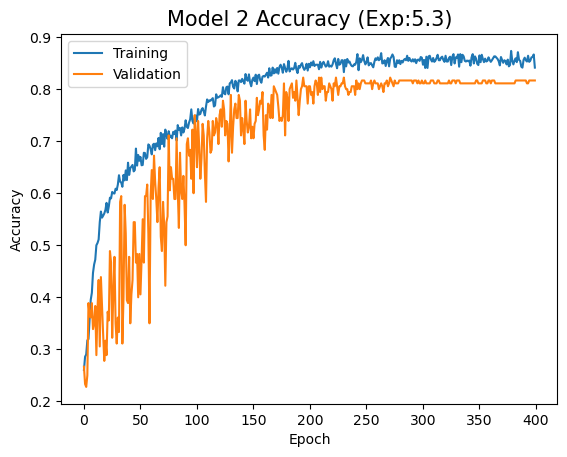

In [27]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:5.3)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp:5.3)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:5.3)')

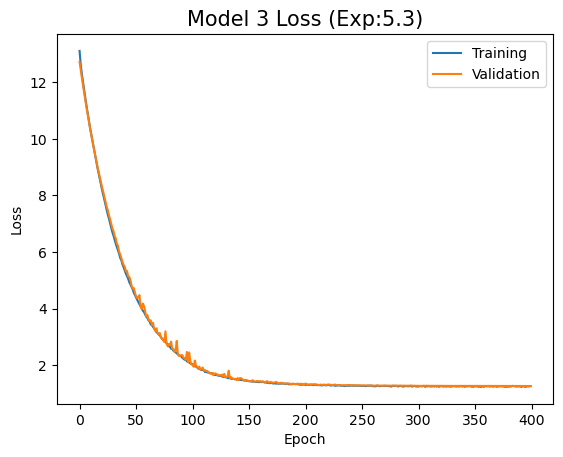

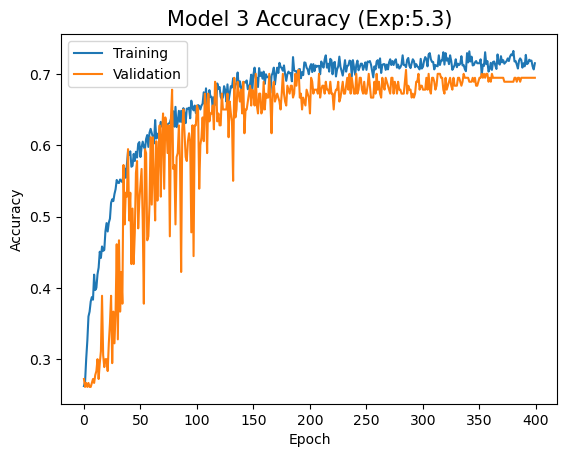

In [28]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:5.3)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:5.3)', fontsize = 15)

In [29]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7904 - loss: 1.1544
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8433 - loss: 1.0544
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7660 - loss: 1.2434


In [30]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


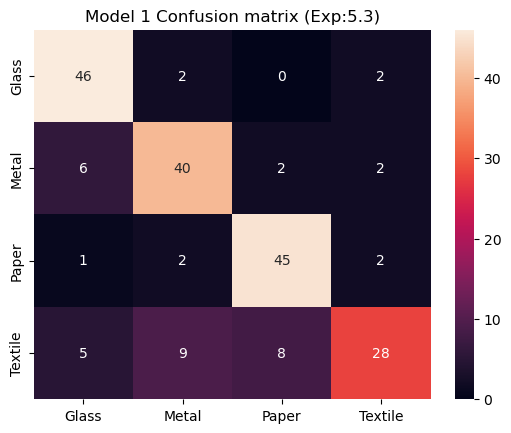

In [31]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sns.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 1 Confusion matrix (Exp:5.3)')
plt.show()

In [32]:
#Obtain the model's prediction for the test_images
predictions2 = model_2.predict(test_images)
pred_label2 = np.argmax(predictions2, axis = 1)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


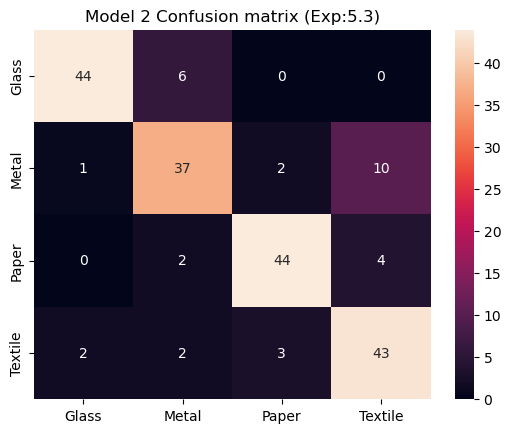

In [33]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sns.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 2 Confusion matrix (Exp:5.3)')
plt.show()

In [34]:
#Obtain the model's prediction for the test_images
predictions3 = model_3.predict(test_images)
pred_label3 = np.argmax(predictions3, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


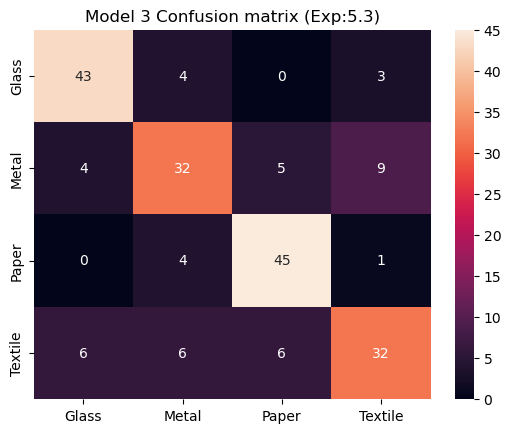

In [47]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sns.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 3 Confusion matrix (Exp:5.3)')
plt.show()

25 random image with actual and predicted label for Model 1


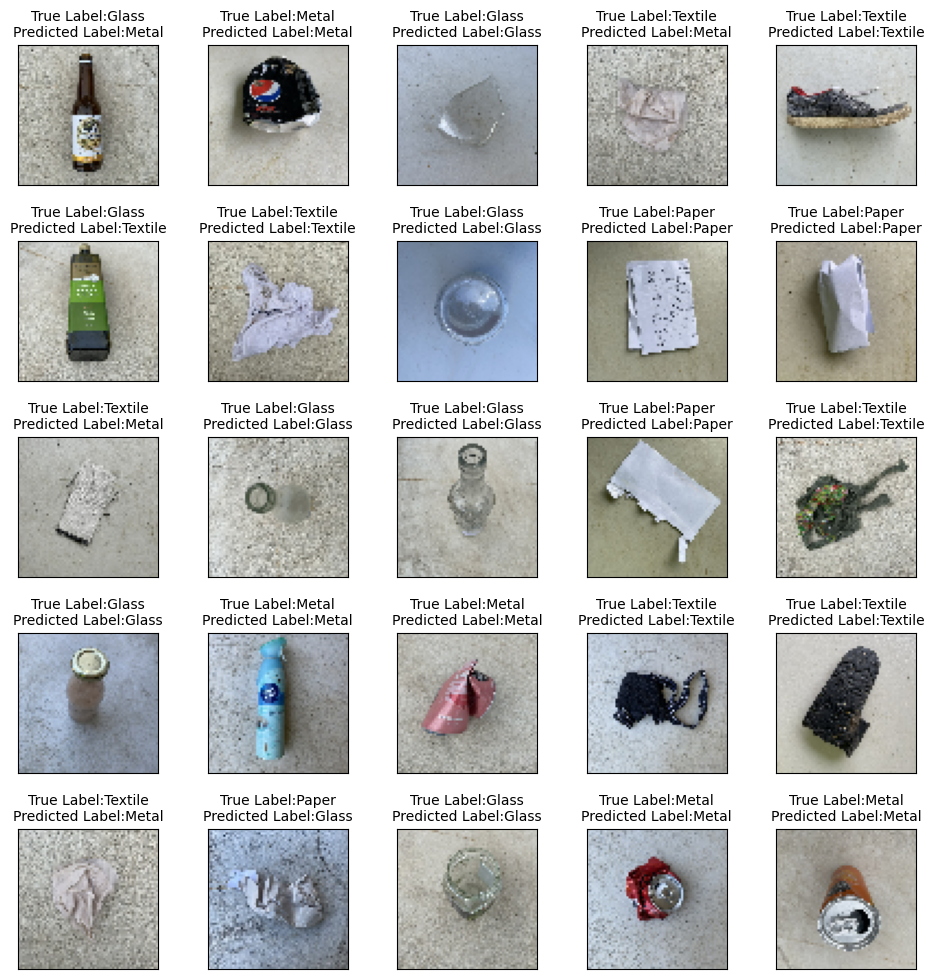

In [36]:
#Display actual and predicted labels for 25 images model 3
print('25 random image with actual and predicted label for Model 1')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label1[i]], fontsize = 10)
    
    
    #plt.show()

25 random image with actual and predicted label for Model 2


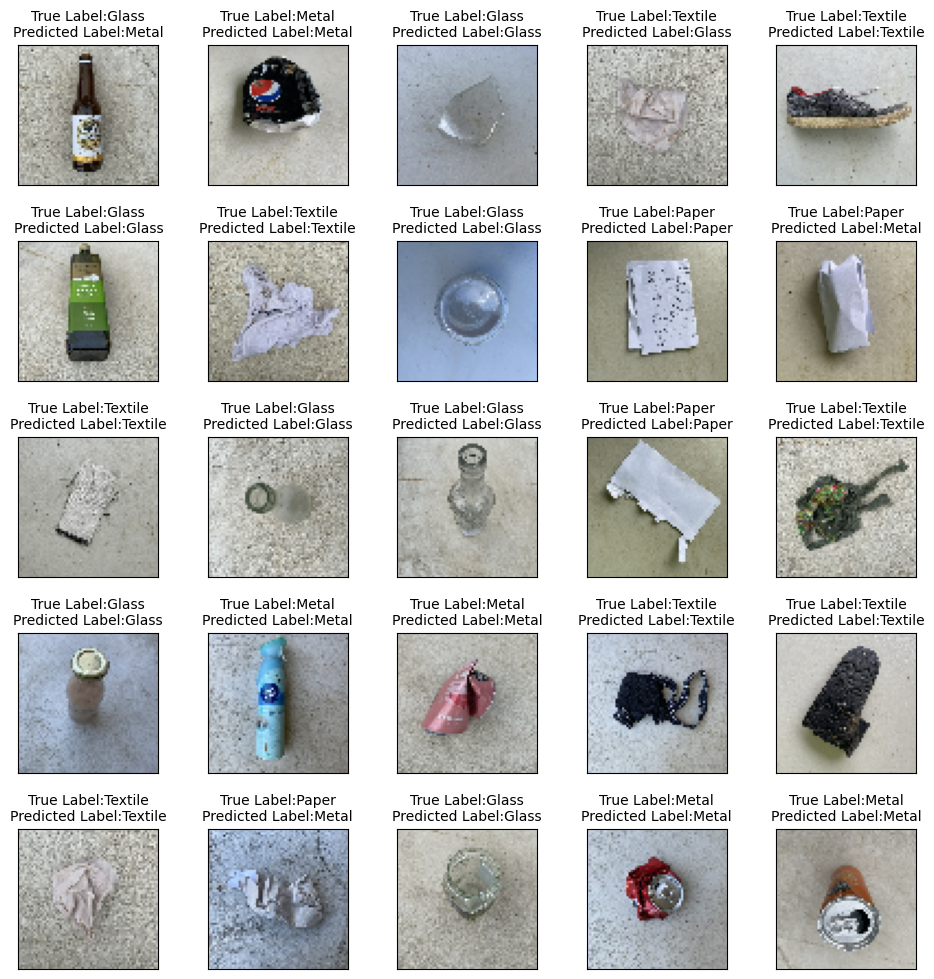

In [37]:
#Display actual and predicted labels for 25 images 
print('25 random image with actual and predicted label for Model 2')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label2[i]], fontsize = 10)
    

25 random image with actual and predicted label for Model 3


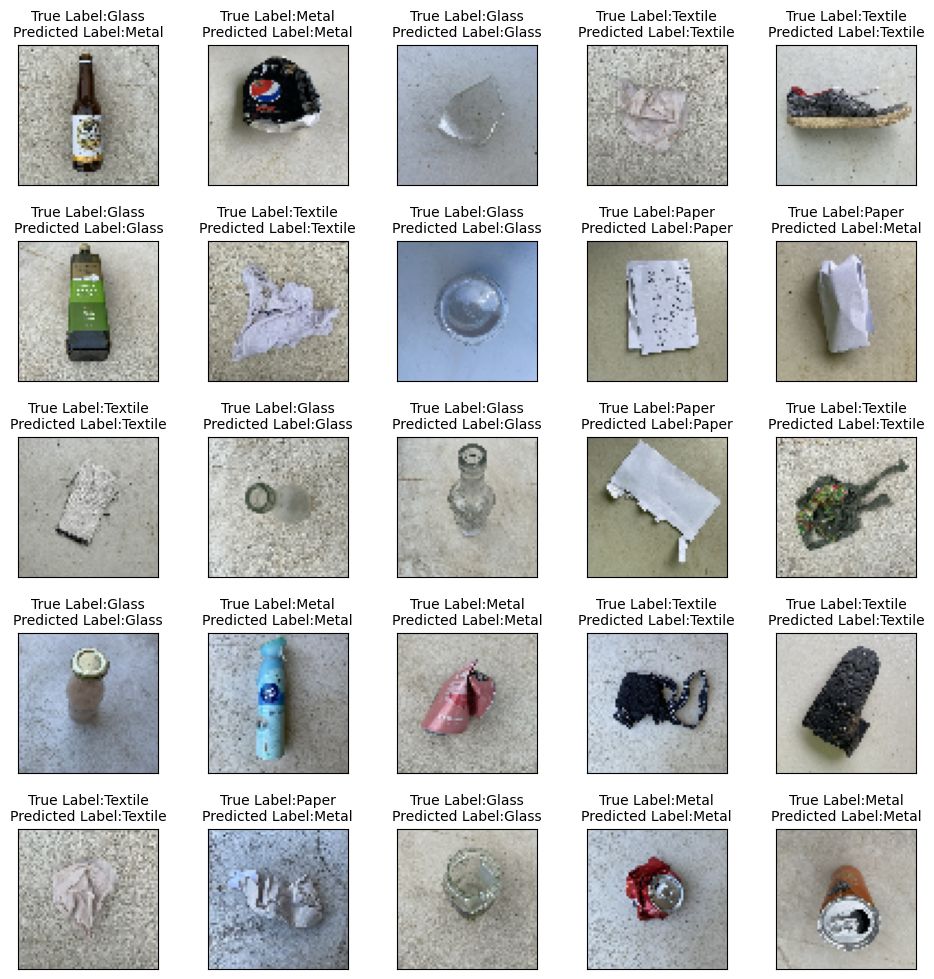

In [38]:
#Display actual and predicted labels for 25 images 
print('25 random image with actual and predicted label for Model 3')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label3[i]], fontsize = 10)
    

In [39]:
def display_mislabel_images(class_names, images, labels):
    """
        Display mislabel images from the images array with its corresponding labels
    """
  
    fig = plt.figure(figsize=(15,15))
    #fig.suptitle("mislabeled images", fontsize=16)
    for i in range(6):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]], fontsize = 15) 
    plt.show()

In [40]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print all the mislabeled images by the classifier
    """
    correct_label = (test_labels == pred_labels)
    mislabeled_indices = np.where(correct_label == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    #actual_label = test_labels[mislabeled_indices]

      
    display_mislabel_images(class_names,  mislabeled_images, mislabeled_labels)

Mislabel image for model 1


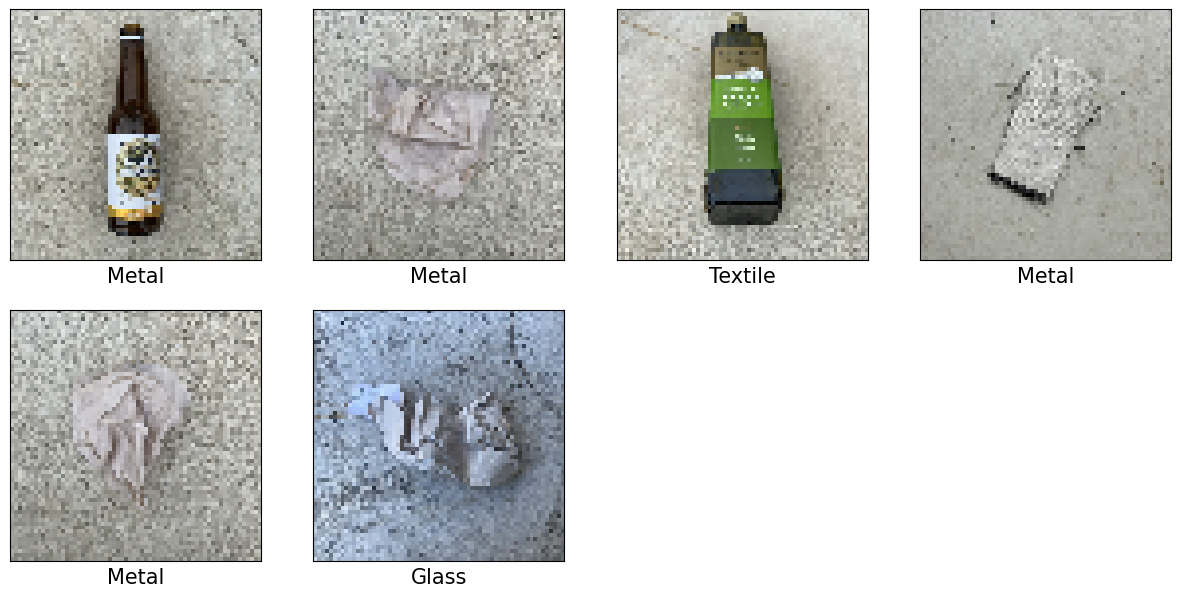

In [41]:
print('Mislabel image for model 1')
print_mislabeled_images(class_names, test_images, test_labels, pred_label1)

Mislabel image for model 2


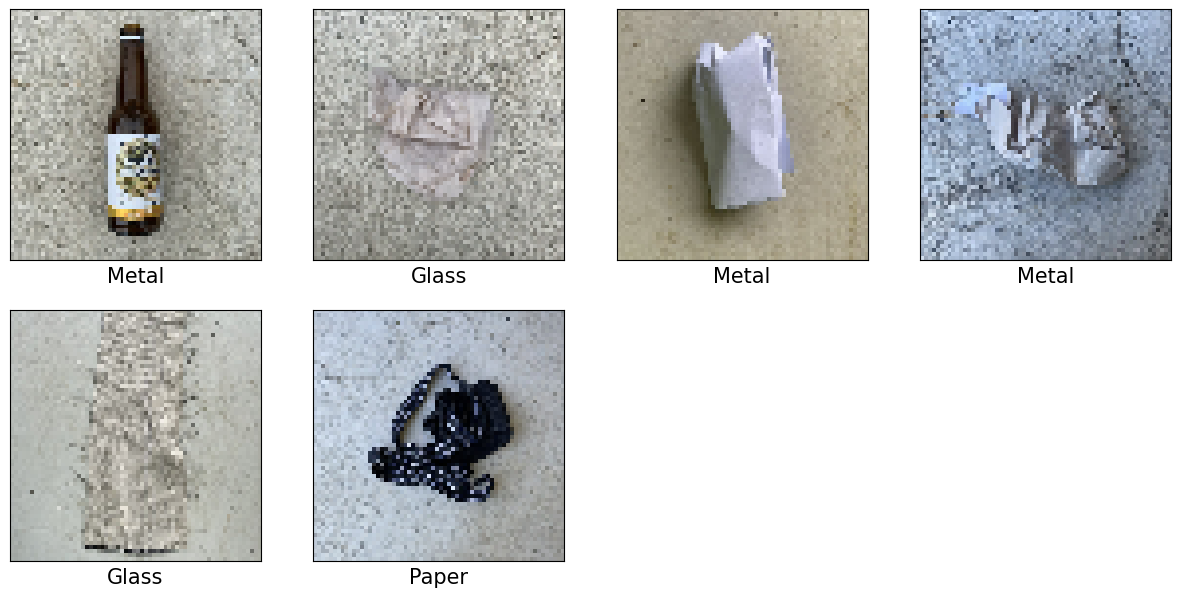

In [42]:
print('Mislabel image for model 2')
print_mislabeled_images(class_names, test_images, test_labels, pred_label2)

Mislabel image for model 3


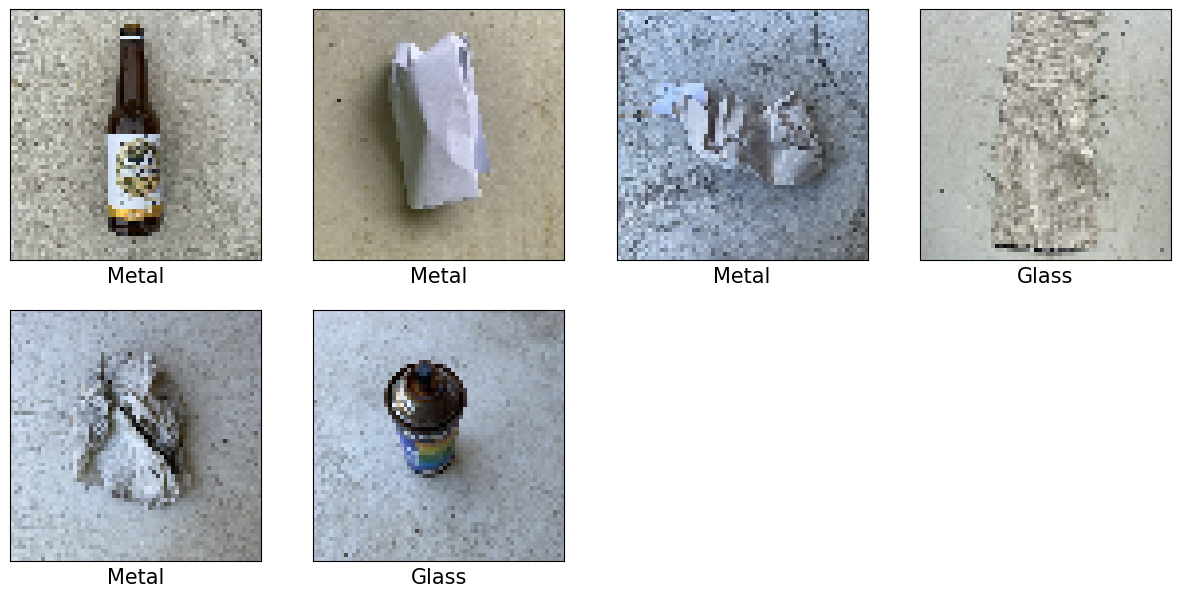

In [43]:
print('Mislabel image for model 3')
print_mislabeled_images(class_names, test_images, test_labels, pred_label3)

## Predict Single Image

Predict start: 2024-12-09 14:46:01.700666


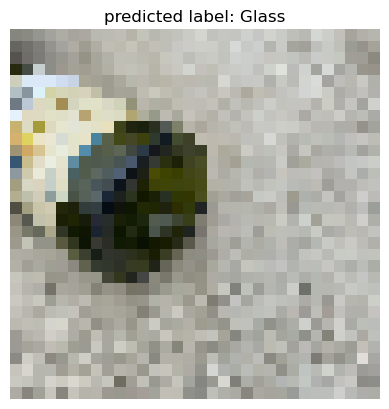

Predict end: 2024-12-09 14:46:01.810814
Prediction time: 0:00:00.110148


In [44]:
# Prediction time for model 1
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (32, 32)
test_image1 = cv2.imread("C:/test_ds/Glass/Glass_2.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
im1= tf.constant(test_image1, dtype = tf.float32)
im1= tf.expand_dims(im1,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_1(im1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)

Predict start: 2024-12-09 14:46:01.818767


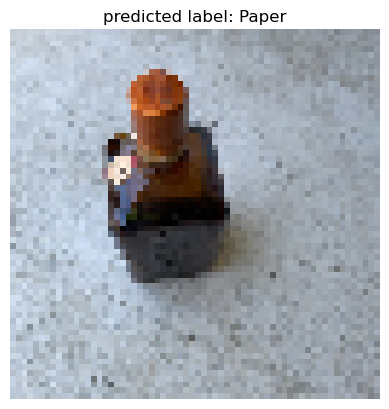

Predict end: 2024-12-09 14:46:01.954201
Prediction time: 0:00:00.135434


In [45]:
# Prediction time for model 2
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (64, 64)
test_image1 = cv2.imread("C:/test_ds/Glass/Glass_10.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
im1= tf.constant(test_image1, dtype = tf.float32)
im1= tf.expand_dims(im1,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_2(im1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)

Predict start: 2024-12-09 14:46:01.968493


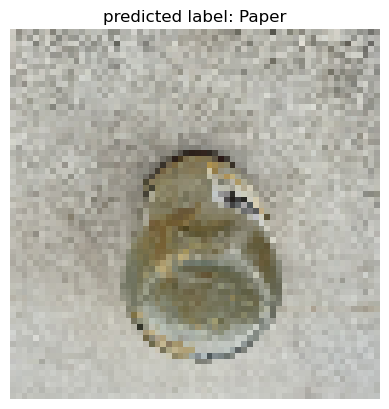

Predict end: 2024-12-09 14:46:02.091747
Prediction time: 0:00:00.123254


In [46]:
# Prediction time for model 3
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (64, 64)
test_image1 = cv2.imread("C:/test_ds/Glass/Glass_4.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
im1= tf.constant(test_image1, dtype = tf.float32)
im1= tf.expand_dims(im1,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_3(im1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)